# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=0)

2018-03-17 19:21:15,453 INFO    : root         : Using LISA logging configuration:
2018-03-17 19:21:15,455 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from scipy import polyfit
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

Populating the interactive namespace from numpy and matplotlib


2018-03-17 19:21:16,342 DEBUG   : JsonConf     : loading JSON...
2018-03-17 19:21:16,343 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-03-17 19:21:16,346 DEBUG   : JsonConf     :    {u'board': {u'big_core': u'A15', u'cores': [u'A7', u'A7', u'A7', u'A7', u'A15', u'A15', u'A15', u'A15'], u'modules': [u'bl', u'cpufreq']}}
2018-03-17 19:21:16,347 DEBUG   : JsonConf     : loading JSON...
2018-03-17 19:21:16,349 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-03-17 19:21:16,350 DEBUG   : JsonConf     :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 78}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1893}}, u'little': {u'cluster': {u'nrg_max': 56}, u'cpu': {u'cap_max': 472, u'nrg_max': 215}}}, u'board': {u'big_core': u'A72', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A72', u'A72'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
2018-03-17 19:21:16,352 DEBUG   : JsonConf     : loading JSON...
2018-03-17 19:21:16,354 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-0

## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.033],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },
    
    # Preload settings for a specific target
    "board"       : 'hikey960',  # juno - JUNO board with mainline hwmon
    
    "device"      : "2450309301A1C7FB",
    
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups', 'thermal', 'cpufreq'],

    "results_dir" : "scheduling_duration_opt",
    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
         '0': 302, '1': 301, '2': 304, '3': 301, '4': 136, '5': 136, '6': 137, '7': 136
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency",
             "sched_energy_calc_duration"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-03-17 19:21:18,039 INFO    : TestEnv      : Using base path: /home/leoy/Work/tools/lisa-ml-20171106
2018-03-17 19:21:18,041 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-03-17 19:21:18,042 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-03-17 19:21:18,043 WARNING : TestEnv      : Wipe previous contents of the results folder:
2018-03-17 19:21:18,044 WARNING : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt
2018-03-17 19:21:18,200 INFO    : TestEnv      : External tools using:
2018-03-17 19:21:18,201 INFO    : TestEnv      :    ANDROID_HOME: /home/leoy/Android/Sdk/
2018-03-17 19:21:18,203 INFO    : TestEnv      :    CATAPULT_HOME: /home/leoy/Work/tools/lisa-ml-20171106/tools/catapult
2018-03-17 19:21:18,205 INFO    : TestEnv      : Devlib modules to load: ['cgroups', 'cpufreq', 'bl', 'hotplug', 'thermal', 'cpuidle']
2018-03-17 19:21:18,206 INFO    : TestEnv      : Connecting Android target

2018-03-17 19:21:22,463 DEBUG   : CGroup.debug : Initialized [debug, 0, ['blkio', 'devices', 'freezer', 'hugetlb', 'debug']]
2018-03-17 19:21:22,556 DEBUG   : CGroup.debug : Controller debug mounted under: /data/local/tmp/devlib-target/cgroups/devlib_cgh0 (noprefix=False)
2018-03-17 19:21:22,559 DEBUG   : cgroups.debug : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-03-17 19:21:22,603 INFO    : CGroups      :   debug        : /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-03-17 19:21:24,549 INFO    : TestEnv      : Attempting to read energy model from target
2018-03-17 19:21:25,742 INFO    : TestEnv      : Topology:
2018-03-17 19:21:25,744 INFO    : TestEnv      :    [[0, 1, 2, 3], [4, 5, 6, 7]]
2018-03-17 19:21:25,878 INFO    : TestEnv      : Loading default EM:
2018-03-17 19:21:25,880 INFO    : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/libs/utils/platforms/hikey960.json
2018-03-17 19:21:25,882 DEBUG   : JsonConf     : loading JSON...
20

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [36]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 10:54:05,496 INFO    : Workload     : Setup new workload simple
2018-01-19 10:54:05,581 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 10:54:05,583 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 10:54:05,584 INFO    : Workload     : ------------------------
2018-01-19 10:54:05,585 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 10:54:05,587 INFO    : Workload     :  | loops count: 1
2018-01-19 10:54:05,588 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 10:54:05,589 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-01-19 10:54:05,590 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload execution

In [37]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 10:54:06,647 INFO    : root         : #### Setup FTrace
2018-01-19 10:54:09,809 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 10:54:09,904 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 10:54:10,023 INFO    : root         : #### Start energy sampling
2018-01-19 10:54:10,024 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 10:54:10,038 INFO    : root         : #### Start RTApp execution
2018-01-19 10:54:10,041 INFO    : Workload     : Workload execution START:
2018-01-19 10:54:10,042 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 10:54:20,266 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 10:54:20,268 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 10:54:20,641 INFO    : root         : #### Stop FTrace
2018-01-19 10:54:20,642 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 10:54:20,855 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 10:54:22,776 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


## Collected results

In [26]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2018-01-19 10:53:18,039 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_per5": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 1000, 
                    "run": 100, 
                    "timer": {
                        "period": 10000, 
                        "ref": "task_per5"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }
    }
}


In [27]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2018-01-19 10:53:18,192 INFO    : root         : Content of the output folder /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt


total 6656
drwxrwxr-x  3 leoy leoy    4096 Jan 19 10:53 .
drwxrwxr-x 12 leoy leoy    4096 Jan 19 10:44 ..
-rw-rw-r--  1 leoy leoy      37 Jan 19 10:53 energy.json
-rw-rw-r--  1 leoy leoy     170 Jan 19 10:53 output.log
-rw-rw-r--  1 leoy leoy    1527 Jan 19 10:53 platform.json
-rw-r--r--  1 leoy leoy  124160 Jan 19 10:53 rt-app-task_per5-0.log
-rw-rw-r--  1 leoy leoy 1851388 Jan 19 10:53 samples.csv
-rw-r--r--  1 leoy leoy     571 Jan 19 10:53 simple_00.json
-rw-rw-r--  1 leoy leoy   50231 Jan 19 10:46 task_perf_task_per5.png
-rw-r--r--  1 leoy leoy 4755456 Jan 19 10:53 trace.dat
drwxrwxr-x  2 leoy leoy    4096 Jan 19 10:49 .trace.dat.cache


In [28]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

2018-01-19 10:53:18,335 INFO    : root         : Energy: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json


{
    "Device0": 27.205571924303829
}


In [29]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

2018-01-19 10:53:18,477 INFO    : root         : Platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 9, 
        "minor": 74, 
        "parts": [
            4, 
            9, 
            74
        ], 
        "rc": null, 
        "release": "4.9.74-04142-gf7518aa", 
        "sha1": "f7518aa", 
        "version": "104 SMP PREEMPT Fri Jan 19 10:42:33 CST 2018", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 433
            }, 
        

In [5]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

## 1% Workload

More information on visualization and trace inspection can be found in **examples/trappy**.

In [6]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:21:31,885 INFO    : Workload     : Setup new workload simple
2018-03-17 19:21:31,960 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:21:31,961 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:21:31,964 INFO    : Workload     : ------------------------
2018-03-17 19:21:31,966 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:21:31,967 INFO    : Workload     :  | loops count: 1
2018-03-17 19:21:31,969 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:21:31,972 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-03-17 19:21:31,977 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


In [7]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:21:32,240 INFO    : root         : #### Setup FTrace
2018-03-17 19:21:35,507 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:21:35,576 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:21:35,677 INFO    : root         : #### Start energy sampling
2018-03-17 19:21:35,680 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-XgSzXb
2018-03-17 19:21:35,690 INFO    : root         : #### Start RTApp execution
2018-03-17 19:21:35,692 INFO    : Workload     : Workload execution START:
2018-03-17 19:21:35,693 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:21:45,874 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-03-17 19:21:45,876 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-XgSzXb/0000000000
2018-03-17 19:21:46,230 INFO    : root         : #### Stop FTrace
2018-03-17 19:21:46,232 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:21:46,441 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-03-17 19:21:48,451 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [8]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


## RTApp task performance plots

2018-03-17 19:21:49,754 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:21:49,756 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:21:49,968 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.83, std: 0.08


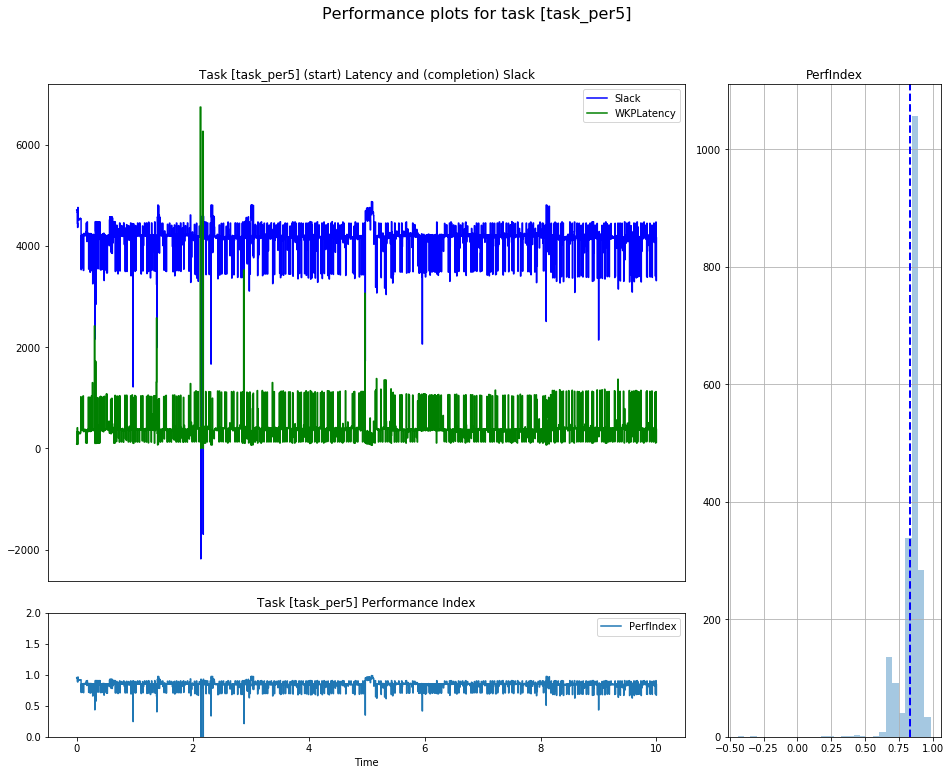

In [9]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [10]:
# Analyse CPU utilization standard devation
def analysis_energy_calculation_duration():

    df = trace.data_frame.trace_event('sched_energy_calc_duration')
    
    if df.empty:
        return
    
    calc_duration_df = pd.DataFrame(
        {
            'max': [int(df['duration'].max())],
            'min': [int(df['duration'].min())],
            'mean': [int(df['duration'].mean())],
        },
    )
    
    return calc_duration_df

In [11]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:21:51,279 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-03-17 19:21:51,280 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib']
2018-03-17 19:21:51,283 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f193789ca10> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f1937948f50> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:21:51,788 DEBUG   : Trace        : Events found on trace:
2018-03-17 19:21:51,789 DEBUG   : Trace        :  - cpu_frequen

2018-03-17 19:21:51,962 DEBUG   : Analysis     :    frequency
2018-03-17 19:21:51,963 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:21:51,966 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f1937914c90>] local data frames
2018-03-17 19:21:51,967 DEBUG   : Trace        :    activations_df
2018-03-17 19:21:51,968 DEBUG   : Trace        :    latency_df
2018-03-17 19:21:51,969 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:21:51,970 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:21:51,971 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:21:51,973 DEBUG   : Trace        :    trace_event
2018-03-17 19:21:51,974 DEBUG   : Analysis     :    latency


In [12]:
analysis_energy_calculation_duration()

,max,mean,min
0,61458,17267,5208


# 5% workload

In [13]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=5,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:21:52,135 INFO    : Workload     : Setup new workload simple
2018-03-17 19:21:52,226 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:21:52,228 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:21:52,230 INFO    : Workload     : ------------------------
2018-03-17 19:21:52,231 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:21:52,232 INFO    : Workload     :  | loops count: 1
2018-03-17 19:21:52,234 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:21:52,236 INFO    : Workload     : |  period     5000 [us], duty_cycle   5 %
2018-03-17 19:21:52,237 INFO    : Workload     : |  run_time    250 [us], sleep_time   4750 [us]


In [14]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:21:52,296 INFO    : root         : #### Setup FTrace
2018-03-17 19:21:55,396 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:21:55,466 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:21:55,573 INFO    : root         : #### Start energy sampling
2018-03-17 19:21:55,575 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-XgSzXb
2018-03-17 19:21:55,593 INFO    : root         : #### Start RTApp execution
2018-03-17 19:21:55,598 INFO    : Workload     : Workload execution START:
2018-03-17 19:21:55,601 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:22:05,864 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-03-17 19:22:05,866 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-XgSzXb/0000000000
2018-03-17 19:22:06,225 INFO    : root         : #### Stop FTrace
2018-03-17 19:22:06,226 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:22:06,449 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-03-17 19:22:08,385 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [15]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:200: UserWarning: Cached data is from another trace, invalidating cache.
  warnings.warn(warnstr)


2018-03-17 19:22:09,702 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:22:09,703 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:22:09,900 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.65, std: 0.24


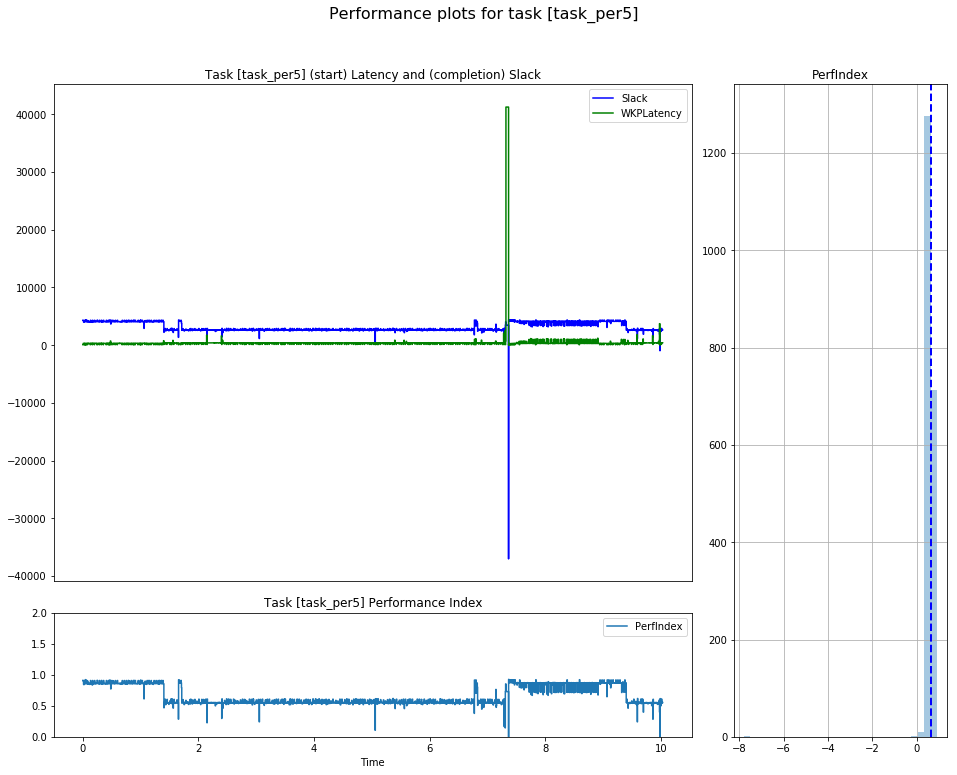

In [16]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [17]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:22:11,058 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-03-17 19:22:11,060 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:22:11,061 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f19378a9ed0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f19377432d0> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:22:11,550 DEBUG   : Trace        : Events found on trace:
2018-03-17 19:22:11,552 DEBUG   : Trace

2018-03-17 19:22:11,774 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:22:11,775 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:22:11,777 DEBUG   : Trace        :    trace_event
2018-03-17 19:22:11,778 DEBUG   : Analysis     :    frequency
2018-03-17 19:22:11,779 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:22:11,780 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f1937899190>] local data frames
2018-03-17 19:22:11,781 DEBUG   : Trace        :    activations_df
2018-03-17 19:22:11,782 DEBUG   : Trace        :    latency_df
2018-03-17 19:22:11,783 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:22:11,785 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:22:11,786 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:22:11,787 DEBUG   : Trace        :    trace_event
2018-03-17 19:22:11,788 DEBUG   : Analysis     :    latency


In [18]:
analysis_energy_calculation_duration()

,max,mean,min
0,60938,21227,4688


# 10% workload

In [19]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:22:11,931 INFO    : Workload     : Setup new workload simple
2018-03-17 19:22:12,014 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:22:12,016 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:22:12,019 INFO    : Workload     : ------------------------
2018-03-17 19:22:12,020 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:22:12,021 INFO    : Workload     :  | loops count: 1
2018-03-17 19:22:12,022 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:22:12,024 INFO    : Workload     : |  period     5000 [us], duty_cycle  10 %
2018-03-17 19:22:12,025 INFO    : Workload     : |  run_time    500 [us], sleep_time   4500 [us]


In [20]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:22:12,089 INFO    : root         : #### Setup FTrace
2018-03-17 19:22:15,173 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:22:15,273 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:22:15,387 INFO    : root         : #### Start energy sampling
2018-03-17 19:22:15,388 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-XgSzXb
2018-03-17 19:22:15,402 INFO    : root         : #### Start RTApp execution
2018-03-17 19:22:15,404 INFO    : Workload     : Workload execution START:
2018-03-17 19:22:15,406 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:22:25,620 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-03-17 19:22:25,621 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-XgSzXb/0000000000
2018-03-17 19:22:25,991 INFO    : root         : #### Stop FTrace
2018-03-17 19:22:25,993 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:22:26,228 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-03-17 19:22:28,154 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [21]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:22:29,342 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:22:29,343 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:22:29,633 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.51, std: 0.14


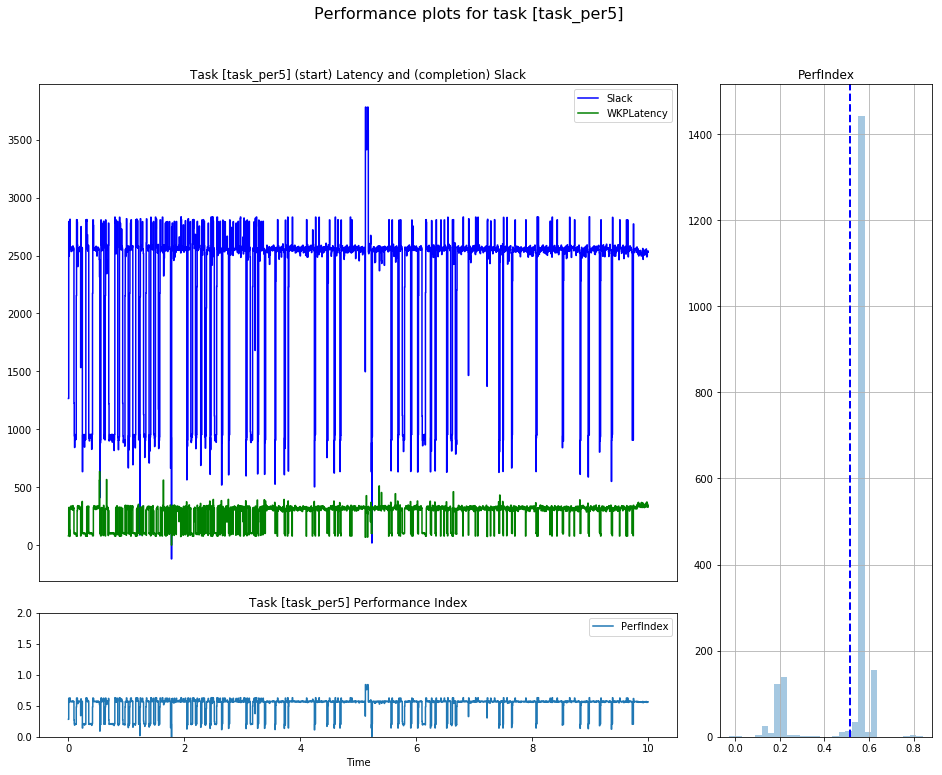

In [22]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [23]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:22:30,867 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-03-17 19:22:30,868 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:22:30,870 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f1937576810> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f1937576b50> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:22:31,419 DEBUG   : Trace        : Events found on trace:
2018-03-17 19:2

2018-03-17 19:22:31,680 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:22:31,684 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:22:31,686 DEBUG   : Trace        :    trace_event
2018-03-17 19:22:31,688 DEBUG   : Analysis     :    frequency
2018-03-17 19:22:31,690 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:22:31,691 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f19378a9290>] local data frames
2018-03-17 19:22:31,693 DEBUG   : Trace        :    activations_df
2018-03-17 19:22:31,694 DEBUG   : Trace        :    latency_df
2018-03-17 19:22:31,695 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:22:31,696 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:22:31,697 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:22:31,701 DEBUG   : Trace        :    trace_event
2018-03-17 19:22:31,702 DEBUG   : Analysis     :    latency


In [24]:
analysis_energy_calculation_duration()

,max,mean,min
0,54166,17019,5208


# 20% Workload

In [25]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:22:31,853 INFO    : Workload     : Setup new workload simple
2018-03-17 19:22:31,927 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:22:31,929 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:22:31,930 INFO    : Workload     : ------------------------
2018-03-17 19:22:31,931 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:22:31,933 INFO    : Workload     :  | loops count: 1
2018-03-17 19:22:31,934 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:22:31,936 INFO    : Workload     : |  period     5000 [us], duty_cycle  20 %
2018-03-17 19:22:31,939 INFO    : Workload     : |  run_time   1000 [us], sleep_time   4000 [us]


In [26]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:22:32,016 INFO    : root         : #### Setup FTrace
2018-03-17 19:22:35,168 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:22:35,249 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:22:35,356 INFO    : root         : #### Start energy sampling
2018-03-17 19:22:35,359 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-XgSzXb
2018-03-17 19:22:35,382 INFO    : root         : #### Start RTApp execution
2018-03-17 19:22:35,384 INFO    : Workload     : Workload execution START:
2018-03-17 19:22:35,386 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:22:45,585 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-03-17 19:22:45,588 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-XgSzXb/0000000000
2018-03-17 19:22:45,957 INFO    : root         : #### Stop FTrace
2018-03-17 19:22:45,958 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:22:46,171 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-03-17 19:22:48,048 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [27]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:22:49,262 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:22:49,264 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:22:49,474 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.45, std: 0.04


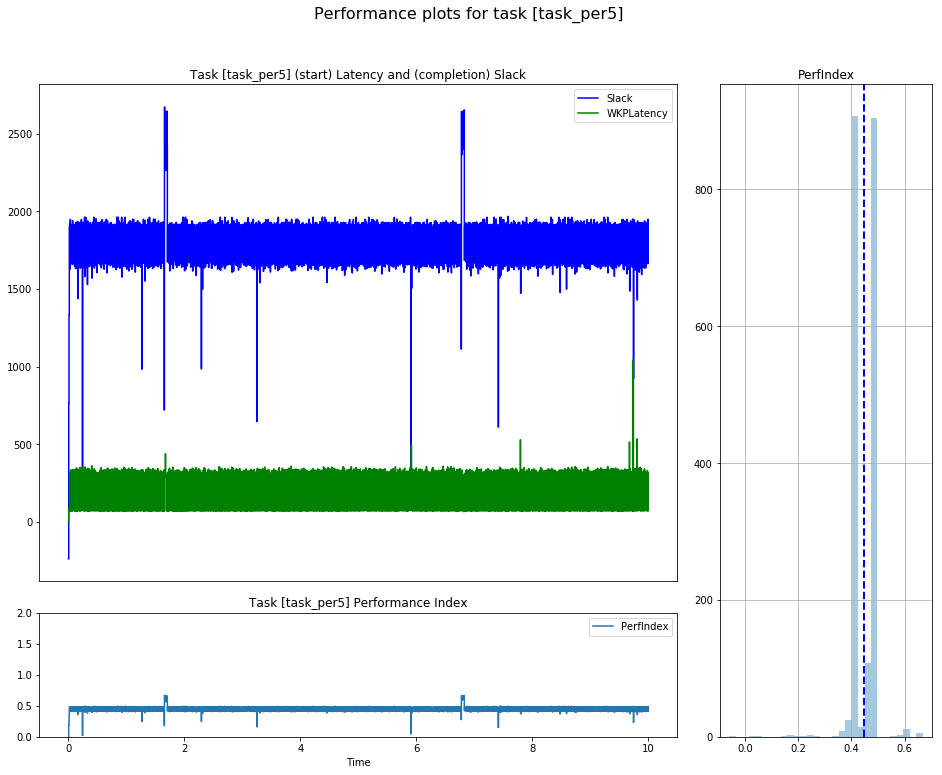

In [28]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [29]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:22:50,859 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-03-17 19:22:50,865 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:22:50,867 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f1937760490> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f1937760850> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:22:51,395 DEBUG   : Trace        : Events found o

2018-03-17 19:22:51,562 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:22:51,563 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:22:51,564 DEBUG   : Trace        :    trace_event
2018-03-17 19:22:51,565 DEBUG   : Analysis     :    frequency
2018-03-17 19:22:51,566 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:22:51,567 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f19374536d0>] local data frames
2018-03-17 19:22:51,568 DEBUG   : Trace        :    activations_df
2018-03-17 19:22:51,571 DEBUG   : Trace        :    latency_df
2018-03-17 19:22:51,574 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:22:51,576 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:22:51,577 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:22:51,578 DEBUG   : Trace        :    trace_event
2018-03-17 19:22:51,579 DEBUG   : Analysis     :    latency


In [30]:
analysis_energy_calculation_duration()

,max,mean,min
0,39583,13914,5208


# 30% Workload

In [31]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=30,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:22:51,703 INFO    : Workload     : Setup new workload simple
2018-03-17 19:22:51,788 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:22:51,789 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:22:51,790 INFO    : Workload     : ------------------------
2018-03-17 19:22:51,792 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:22:51,793 INFO    : Workload     :  | loops count: 1
2018-03-17 19:22:51,794 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:22:51,795 INFO    : Workload     : |  period     5000 [us], duty_cycle  30 %
2018-03-17 19:22:51,796 INFO    : Workload     : |  run_time   1500 [us], sleep_time   3500 [us]


In [32]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:22:51,859 INFO    : root         : #### Setup FTrace
2018-03-17 19:22:54,927 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:22:55,022 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:22:55,132 INFO    : root         : #### Start energy sampling
2018-03-17 19:22:55,134 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-XgSzXb
2018-03-17 19:22:55,146 INFO    : root         : #### Start RTApp execution
2018-03-17 19:22:55,148 INFO    : Workload     : Workload execution START:
2018-03-17 19:22:55,149 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:23:05,324 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-03-17 19:23:05,325 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-XgSzXb/0000000000
2018-03-17 19:23:05,679 INFO    : root         : #### Stop FTrace
2018-03-17 19:23:05,680 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:23:05,928 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-03-17 19:23:07,855 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [33]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:23:09,051 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:23:09,053 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:23:09,310 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.36, std: 0.03


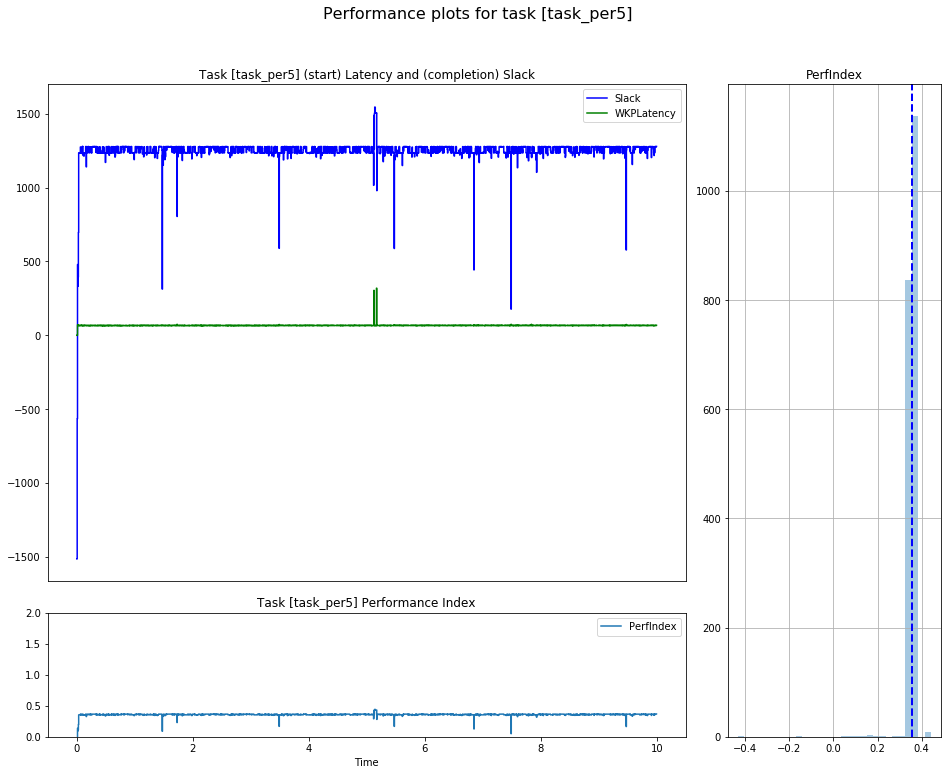

In [34]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [35]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:23:10,397 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-03-17 19:23:10,399 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:23:10,401 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f1937777850> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f1937777510> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:23:10,959 DEBUG   : Trace

2018-03-17 19:23:11,165 DEBUG   : Analysis     :    idle
2018-03-17 19:23:11,166 DEBUG   : Analysis     : Filename: frequency_analysis
2018-03-17 19:23:11,168 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f1937558710>] local data frames
2018-03-17 19:23:11,170 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:23:11,172 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:23:11,174 DEBUG   : Trace        :    trace_event
2018-03-17 19:23:11,176 DEBUG   : Analysis     :    frequency
2018-03-17 19:23:11,178 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:23:11,179 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f1937558390>] local data frames
2018-03-17 19:23:11,181 DEBUG   : Trace        :    activations_df
2018-03-17 19:23:11,182 DEBUG   : Trace        :    latency_df
2018-03-17 19:23:11,184 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:23:

In [36]:
analysis_energy_calculation_duration()

,max,mean,min
0,41667,15002,4166


# 40% Workload

In [37]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=40,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:23:11,319 INFO    : Workload     : Setup new workload simple
2018-03-17 19:23:11,409 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:23:11,410 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:23:11,412 INFO    : Workload     : ------------------------
2018-03-17 19:23:11,413 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:23:11,414 INFO    : Workload     :  | loops count: 1
2018-03-17 19:23:11,415 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:23:11,416 INFO    : Workload     : |  period     5000 [us], duty_cycle  40 %
2018-03-17 19:23:11,418 INFO    : Workload     : |  run_time   2000 [us], sleep_time   3000 [us]


In [38]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:23:11,465 INFO    : root         : #### Setup FTrace
2018-03-17 19:23:14,529 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:23:14,622 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:23:14,728 INFO    : root         : #### Start energy sampling
2018-03-17 19:23:14,730 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-XgSzXb
2018-03-17 19:23:14,743 INFO    : root         : #### Start RTApp execution
2018-03-17 19:23:14,750 INFO    : Workload     : Workload execution START:
2018-03-17 19:23:14,751 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:23:24,960 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-03-17 19:23:24,962 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-XgSzXb/0000000000
2018-03-17 19:23:25,318 INFO    : root         : #### Stop FTrace
2018-03-17 19:23:25,319 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:23:25,575 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-03-17 19:23:27,509 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [39]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:23:28,756 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:23:28,757 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:23:29,018 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.50, std: 0.05


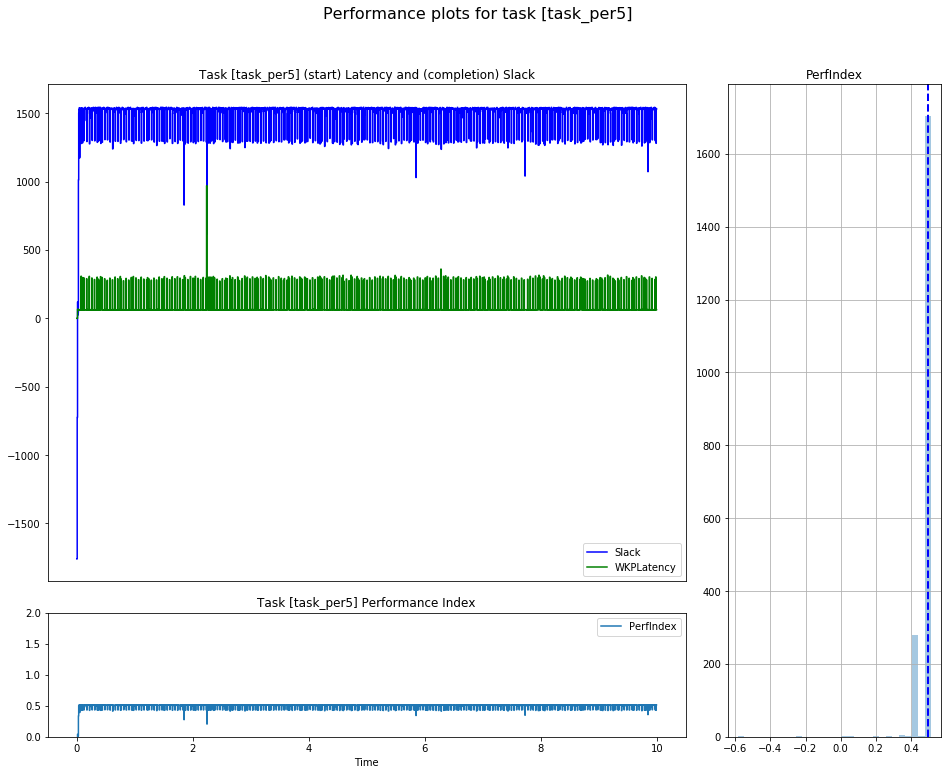

In [40]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [41]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:23:30,142 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-03-17 19:23:30,144 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:23:30,145 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f19379482d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f1937948090> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:2

2018-03-17 19:23:30,909 DEBUG   : Trace        :    trace_event
2018-03-17 19:23:30,910 DEBUG   : Analysis     :    idle
2018-03-17 19:23:30,912 DEBUG   : Analysis     : Filename: frequency_analysis
2018-03-17 19:23:30,913 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f19373062d0>] local data frames
2018-03-17 19:23:30,914 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:23:30,916 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:23:30,917 DEBUG   : Trace        :    trace_event
2018-03-17 19:23:30,918 DEBUG   : Analysis     :    frequency
2018-03-17 19:23:30,919 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:23:30,921 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f1937306950>] local data frames
2018-03-17 19:23:30,922 DEBUG   : Trace        :    activations_df
2018-03-17 19:23:30,923 DEBUG   : Trace        :    latency_df
2018-03-17 19:23:30,924 DEB

In [42]:
analysis_energy_calculation_duration()

,max,mean,min
0,58334,23412,3646
